In [65]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

In [21]:
user_behavior = pd.read_csv("data\\steam-200k.csv", header=None).drop(columns=4)
user_behavior.columns = ["user_id", "game_name", "behavior", "amount"]

# User Based (using just "play" behavior)

In [22]:
# get only user plays
user_plays = user_behavior[user_behavior["behavior"] == "play"].drop(columns="behavior")

In [23]:
# make sure each user only has one play amount for each game
user_plays = user_plays.groupby(["user_id", "game_name"]).sum().reset_index()

In [24]:
users_sorted = user_plays.groupby("user_id").count().reset_index().sort_values("amount", ascending=False)
games_sorted = user_plays.groupby("game_name").count().reset_index().sort_values("amount", ascending=False)

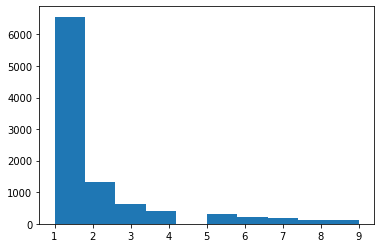

In [44]:
plt.hist(users_sorted['amount'][users_sorted['amount'] < 10])
plt.show()

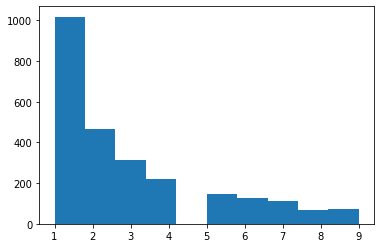

In [43]:
plt.hist(users_sorted['amount'][users_sorted['amount'] < 10])
plt.show()

In [64]:
# only include users that have 
# user_plays = user_plays[user_plays['user_id'].isin(users_sorted[users_sorted['amount'] >= 5]['user_id'])]

,user_id,game_name,amount
0,5250,Alien Swarm,4.9
1,5250,Cities Skylines,144.0
2,5250,Deus Ex Human Revolution,62.0
3,5250,Dota 2,0.2
4,5250,Portal 2,13.6
...,...,...,...
70467,309404240,AdVenture Capitalist,0.7
70468,309404240,Mitos.is The Game,2.2
70469,309404240,Team Fortress 2,2.2
70470,309404240,Transformice,0.3


In [56]:
user_games = user_plays.pivot(index="user_id", columns="game_name", values="amount")

In [57]:
user_games.shape

(11350, 3600)

In [48]:
user_similarities = pd.DataFrame(cosine_similarity(user_games.fillna(0)), columns=user_games.index, index=user_games.index)

In [123]:
ug = user_games[['Sid Meier\'s Civilization V', 'Left 4 Dead', 'Dota 2']].dropna(axis=0, thresh=1).head()

In [213]:
ug 

game_name,Sid Meier's Civilization V,Left 4 Dead,Dota 2
user_id,,,
5250,NaN,NaN,0.2
298950,135.0,0.9,0.5
561758,NaN,8.2,NaN
748719,67.0,NaN,NaN
975449,NaN,158.0,54.0


In [219]:
us = pd.DataFrame(cosine_similarity(ug.fillna(0)), columns=ug.index, index=ug.index)

user_id,5250,298950,561758,748719,975449
user_id,,,,,
5250,1.000000,0.003704,0.000000,0.000000,0.323405
298950,0.003704,1.000000,0.006666,0.999971,0.007506
561758,0.000000,0.006666,1.000000,0.000000,0.946260
748719,0.000000,0.999971,0.000000,1.000000,0.000000
975449,0.323405,0.007506,0.946260,0.000000,1.000000


In [242]:
us.dot(ug.fillna(0))

game_name,Sid Meier's Civilization V,Left 4 Dead,Dota 2
user_id,,,
5250,0.499985,51.101399,17.665748
298950,201.998052,2.140610,0.906064
561758,0.899974,157.715156,51.101399
748719,201.996074,0.899974,0.499985
975449,1.013308,165.766091,54.068434


In [239]:
us.fillna(0).loc[5250] * ug.T

user_id,5250,298950,561758,748719,975449
game_name,,,,,
Sid Meier's Civilization V,NaN,0.499985,NaN,0.0,NaN
Left 4 Dead,NaN,0.003333,0.0,NaN,51.098066
Dota 2,0.2,0.001852,NaN,NaN,17.463896


In [252]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [253]:
train_test_split(ug.fillna(0))

TypeError: '(0, slice(None, None, None))' is an invalid key